In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import rasterio
import seaborn as sns
import joblib
import missingno as mno

## Load trained model

In [2]:
best_xgb_model = joblib.load('trained_model.pkl')

## Lat and Lon

In [3]:
import random
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm

# Load the shapefile for Nevada
Nevada = gpd.read_file('Nevada/nevada.shp')

# Get the Polygon for Switzerland
Nevada_polygon = Nevada.geometry.unary_union

# Define the bounding box of the polygon
bbox = Nevada_polygon.bounds

# Number of random points to generate
num_points = 10000

# Generate random points within the bounding rectangle
random_points = []

while len(random_points) < num_points:
    random_lon = random.uniform(bbox[0], bbox[2])
    random_lat = random.uniform(bbox[1], bbox[3])
    random_point = Point(random_lon, random_lat)
    random_points.append({'Longitude': random_point.x, 'Latitude': random_point.y})

In [4]:
# Create a list to store filtered points
filtered_points = []

progress_bar = tqdm(total=num_points, position=0)

# Filter points to keep only those within the Colombia shape
for point in tqdm(random_points, position=1, desc="Filtering Points"):
    if Point(point['Longitude'], point['Latitude']).within(Nevada_polygon):
        filtered_points.append(point)
    progress_bar.update(1)

progress_bar.close()

# Create a DataFrame with the generated and filtered points
points = pd.DataFrame(filtered_points)

100%|██████████| 10000/10000 [00:04<00:00, 2466.99it/s]


In [5]:
points.head()

,Longitude,Latitude
0,-114.142350,41.305919
1,-119.206810,41.828469
2,-115.316083,39.056995
3,-115.860218,40.135393
4,-114.454075,38.985204


In [7]:
points.to_csv('Nevada/points_nv.csv')
points = pd.read_csv('Nevada/points_nv.csv')

## Add elevation

In [8]:
import rasterio
from pyproj import CRS, Transformer

# Rescale the elevation values to get actual values as they are downscaled 0-6400 meters
def rescale(val, in_min, in_max, out_min, out_max):
    return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

def get_elevation(lat, lon, dem='data/WorldDEM.tif'):
    with rasterio.open(dem) as src:
        # Define coordinate systems
        in_crs = CRS("EPSG:4326")  # Input coordinate system (WGS84)
        out_crs = src.crs  # Output coordinate system (raster's crs)

        # Create a transformer object
        transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)

        # Transform coordinates
        lon, lat = transformer.transform(lon, lat)

        # Sample the raster at the transformed coordinates
        vals = src.sample([(lon, lat)])
        for val in vals:
            # Upscale the elevation value
            elevation = rescale(val[0], 0, 255, 0, 6400) # 0 and 255 are the min and max values of the DEM
    return elevation


# Use tqdm to show progress
tqdm.pandas()

# Apply the function to each row in your DataFrame
points['Elevation (m)'] = points.progress_apply(lambda row: get_elevation(row['Latitude'], row['Longitude']), axis=1)

100%|██████████| 7151/7151 [00:44<00:00, 160.91it/s]


In [9]:
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m)
0,0,-114.142350,41.305919,1455.686275
1,1,-119.206810,41.828469,1857.254902
2,2,-115.316083,39.056995,2409.411765
3,3,-115.860218,40.135393,1781.960784
4,4,-114.454075,38.985204,1781.960784


## Volcanoes, MOHO, LAB, gravimetrics and Magnetic Susceptibility

### Load datasets

Moho and LAB

In [10]:
file_path = 'data/LithoRef18.xyz'


lab_depth = pd.read_table(file_path, delim_whitespace=True, header=None, names=[
    'LONG', 'LAT', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
    'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'
], skiprows=9)

lab_depth = lab_depth.rename(columns={"LONG": "Longitude", "LAT": "Latitude", "MOHO": "Moho Depth (m)"})

In [11]:
min_lon, max_lon = points['Longitude'].min(), points['Longitude'].max()
min_lat, max_lat = points['Latitude'].min(), points['Latitude'].max()

In [17]:
print(min_lon, min_lat, max_lon, max_lat)

-120.0016579762239 35.0940498207889 -114.04134013883898 41.99334773993865


In [15]:
lab_depth= lab_depth[
    (lab_depth["Latitude"] >= min_lat) & (lab_depth["Latitude"] <= max_lat) &
    (lab_depth["Longitude"] >= min_lon) & (lab_depth["Longitude"] <= max_lon)
]

lab_depth.head()

,Longitude,Latitude,ELEVATION,Moho Depth (m),LAB,RHO_C,RHO_L,RHO_SL,BOTTOM,GEOID,FA,G_zz,G_xx,G_yy
2763,-119.0,37.0,1612.5,-35818.41,-76907.20,2801.70,3294.34,3436.40,-410000.0,3.06,30.06,0.18,-0.13,-0.04
2764,-119.0,39.0,1742.5,-35173.66,-52694.24,2756.82,3267.83,3430.69,-410000.0,3.42,11.53,0.22,-0.13,-0.10
2765,-119.0,41.0,1540.0,-30244.54,-58622.75,2718.38,3279.10,3430.39,-410000.0,3.30,7.05,0.21,-0.09,-0.13
2853,-117.0,37.0,1377.5,-32526.13,-52941.07,2756.09,3270.37,3430.18,-410000.0,1.87,-4.27,0.12,-0.07,-0.05
2854,-117.0,39.0,1970.0,-33167.12,-74112.03,2730.63,3293.13,3436.62,-410000.0,3.51,12.29,0.18,-0.08,-0.09


Volcanoes

In [16]:
volcanos = pd.read_csv('Nevada/USA_volcanoes.csv')
volcanos.head()

,Number,Name,Country,Region,Type,Activity Evidence,Last Known Eruption,Latitude,Longitude,Elevation (Meters),Dominant Rock Type,Tectonic Setting
0,311010,Buldir,United States,Alaska,Stratovolcano,Evidence Uncertain,Unknown,52.350,175.911,656.0,Basalt / Picro-Basalt,Subduction Zone / Intermediate Crust (15-25 km)
1,311020,Kiska,United States,Alaska,Stratovolcano,Eruption Observed,1990 CE,52.103,177.602,1220.0,Andesite / Basaltic Andesite,Subduction Zone / Intermediate Crust (15-25 km)
2,311030,Segula,United States,Alaska,Stratovolcano,Evidence Credible,Unknown,52.015,178.136,1160.0,Andesite / Basaltic Andesite,Subduction Zone / Intermediate Crust (15-25 km)
3,311040,Davidof,United States,Alaska,Stratovolcano,Evidence Uncertain,Unknown,51.970,178.330,328.0,No Data,Subduction Zone / Intermediate Crust (15-25 km)
4,311050,Little Sitkin,United States,Alaska,Stratovolcano,Eruption Observed,1830 CE,51.950,178.543,1174.0,Andesite / Basaltic Andesite,Subduction Zone / Intermediate Crust (15-25 km)


### Feature extracting

Volcanoes

In [19]:
import math

# Load the "points" dataset into GeoDataFrames
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Longitude'], volcanos['Latitude']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano_2 = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in points_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano_2.append(nearest_volcano_distance)

# Add the distances to the "points" dataset as a new column (in meters)
points['Distance To Nearest Volcano (m)'] = distances_to_nearest_volcano_2

In [21]:
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m)
0,0,-114.142350,41.305919,1455.686275,190856.606588
1,1,-119.206810,41.828469,1857.254902,146268.321872
2,2,-115.316083,39.056995,2409.411765,243486.960817
3,3,-115.860218,40.135393,1781.960784,265655.678039
4,4,-114.454075,38.985204,1781.960784,168919.477164


Volcanoes nearby

In [23]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
points['Radius (m)'] = points['Distance To Nearest Volcano (m)'] + 5000
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby_2 = []

# Iterate through each well to count nearby volcanoes
for index, row in points.iterrows():
    well_location = (row['Latitude'], row['Longitude'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Latitude'], x['Longitude'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby_2.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "points" dataset
points['Number of Volcanoes Nearby'] = num_volcanoes_nearby_2

In [24]:
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby
0,0,-114.142350,41.305919,1455.686275,190856.606588,195856.606588,1
1,1,-119.206810,41.828469,1857.254902,146268.321872,151268.321872,1
2,2,-115.316083,39.056995,2409.411765,243486.960817,248486.960817,1
3,3,-115.860218,40.135393,1781.960784,265655.678039,270655.678039,1
4,4,-114.454075,38.985204,1781.960784,168919.477164,173919.477164,1


Moho Depth

In [33]:
from scipy.interpolate import griddata
from tqdm import tqdm

points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
moho_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Longitude'], lab_depth['Latitude']))

# Convert GeoDataFrames to numpy arrays
points_array = points_gdf[['Longitude', 'Latitude']].values
moho_depth_array = moho_depth_gdf[['Longitude', 'Latitude', 'Moho Depth (m)']].values

# Separate the coordinates and values
coordinates, values = moho_depth_array[:, :2], moho_depth_array[:, 2]

# Initialize tqdm for progress bar
pbar = tqdm(total=len(points_array), desc="Interpolating", ncols=100)

# Initialize an empty list to store interpolated Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for point in points_array:
    # Use griddata for interpolation
    moho_depth_value = griddata(coordinates, values, [point], method='cubic')
    
    # Append the interpolated Moho depth value to the list
    moho_depth_values.append(moho_depth_value[0])
    
    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

# Add the interpolated Moho depth values to the "points" dataset as a new column
points['Moho Depth (m)'] = moho_depth_values

Interpolating:   0%|                                                       | 0/7151 [00:00<?, ?it/s]

Interpolating: 100%|██████████████████████████████████████████| 7151/7151 [00:02<00:00, 2988.67it/s]


Magnetic anomaly

In [39]:
import rasterio
from rasterio.warp import transform
from rasterio.crs import CRS

# Load the TIFF file
src = rasterio.open('Nevada/mag_nv1.tif')

# Check if the CRS is defined
if src.crs is None:
    # Set the CRS manually if it's not defined
    with rasterio.open('Nevada/mag_nv1.tif', 'r+') as src:
        src.crs = CRS.from_string('EPSG:4326')  # replace with the correct CRS

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Magnetic Anomaly (nT)'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [42]:
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT)
0,0,-114.142350,41.305919,1455.686275,190856.606588,195856.606588,1,NaN,5.948121
1,1,-119.206810,41.828469,1857.254902,146268.321872,151268.321872,1,NaN,76.944275
2,2,-115.316083,39.056995,2409.411765,243486.960817,248486.960817,1,-32708.286048,-2.699496
3,3,-115.860218,40.135393,1781.960784,265655.678039,270655.678039,1,-32195.583008,7.537642
4,4,-114.454075,38.985204,1781.960784,168919.477164,173919.477164,1,NaN,-15.849328


LAB and gravimetrics

In [46]:
from scipy.interpolate import griddata

# Create GeoDataFrames from datasets
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
lab_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Longitude'], lab_depth['Latitude']))

# Define the grid points for interpolation
grid_x = points_gdf['Longitude']
grid_y = points_gdf['Latitude']

# Define the columns to interpolate
columns_to_interpolate = ['LAB', 'RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy']

# Initialize an empty DataFrame to store interpolated values
interpolated_values = pd.DataFrame(index=points_gdf.index)

# Iterate through each column to interpolate
for column in columns_to_interpolate:
    interpolated_column = griddata(
        (lab_depth_gdf['Longitude'], lab_depth_gdf['Latitude']),
        lab_depth_gdf[column],
        (grid_x, grid_y),
        method='cubic'
    )
    interpolated_values[column] = interpolated_column

# Add the interpolated values to the "gradients" DataFrame
points = pd.concat([points, interpolated_values], axis=1)

NaN Removal

<Axes: >

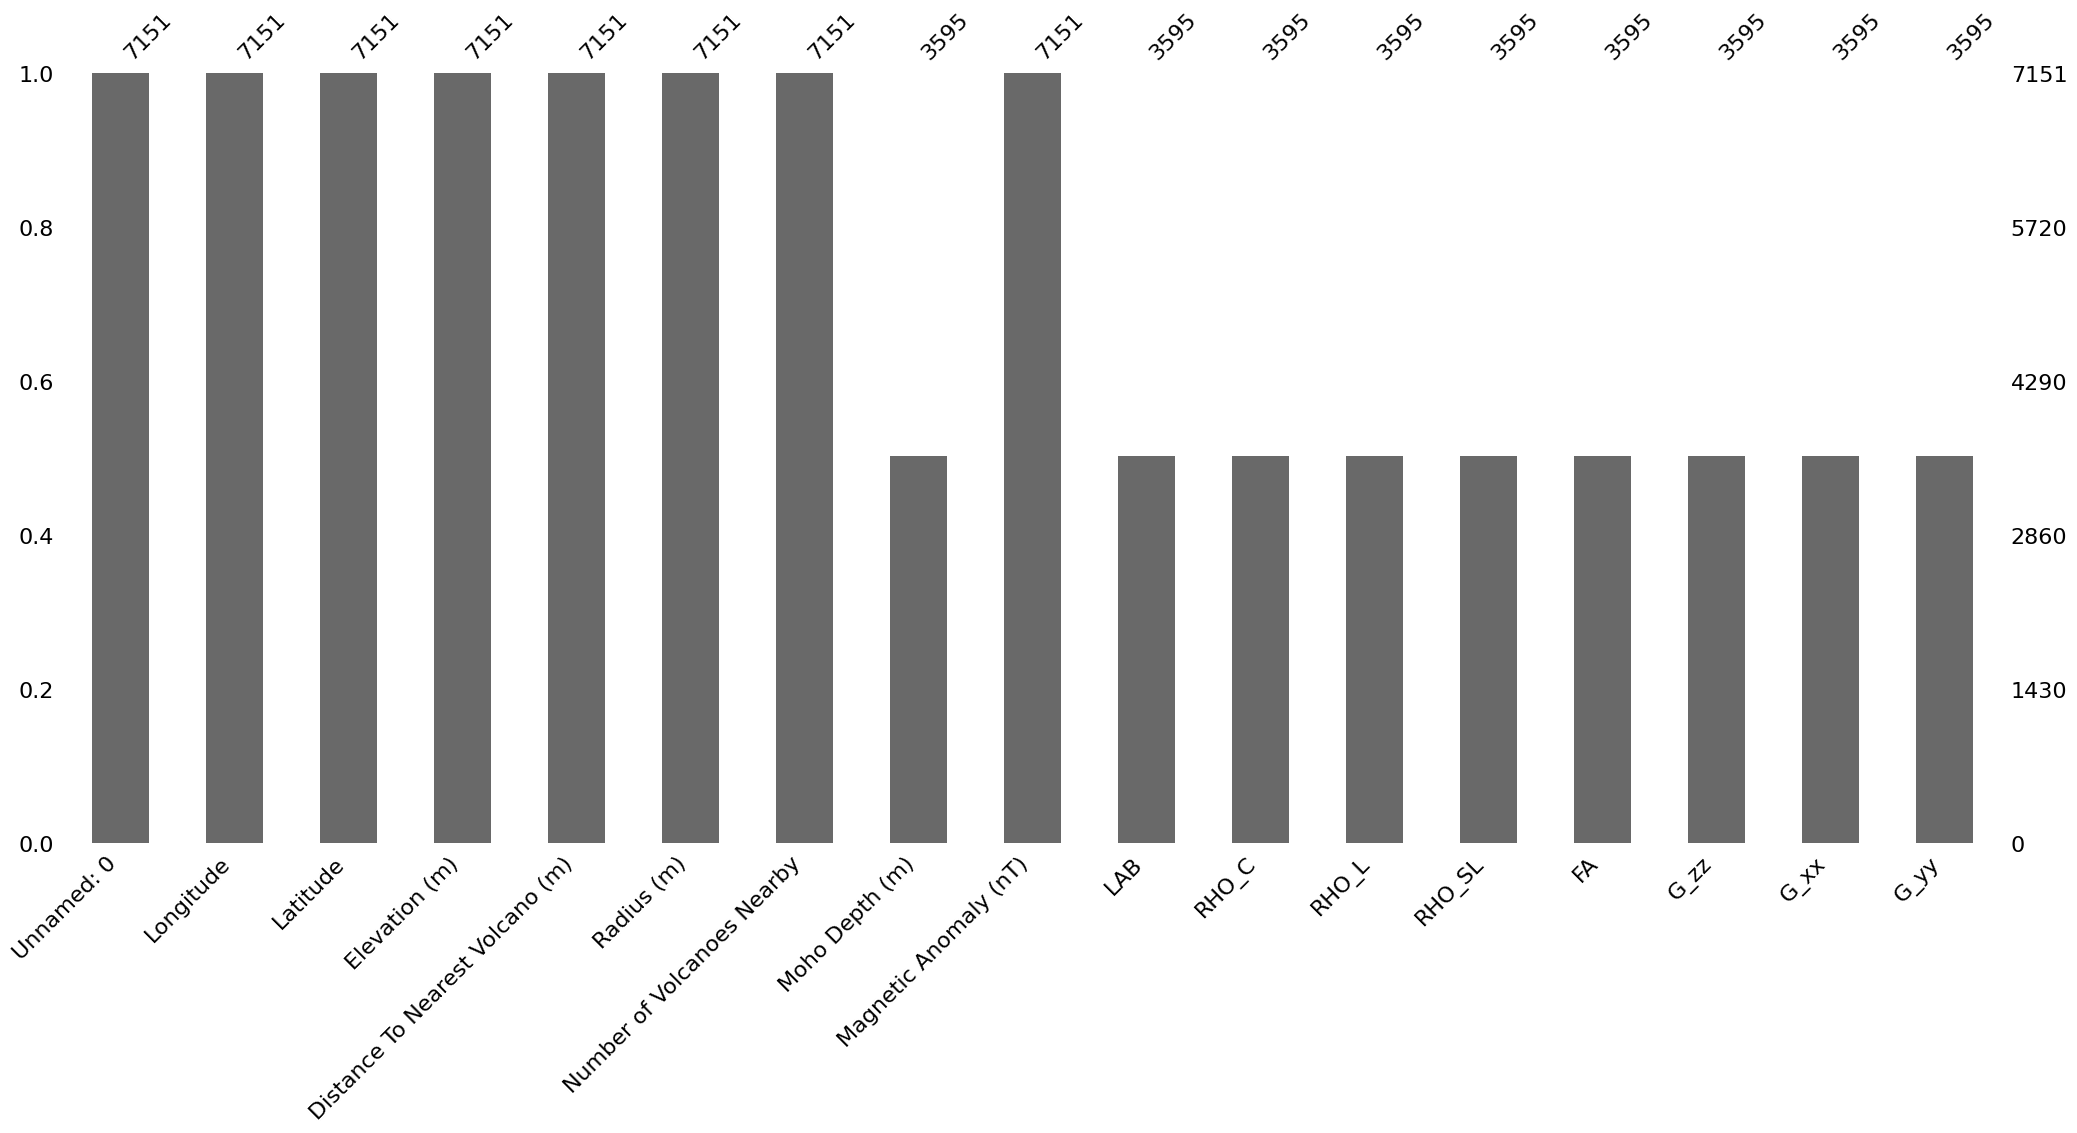

In [49]:
mno.bar(points)

In [52]:
points.dropna(inplace=True)

<Axes: >

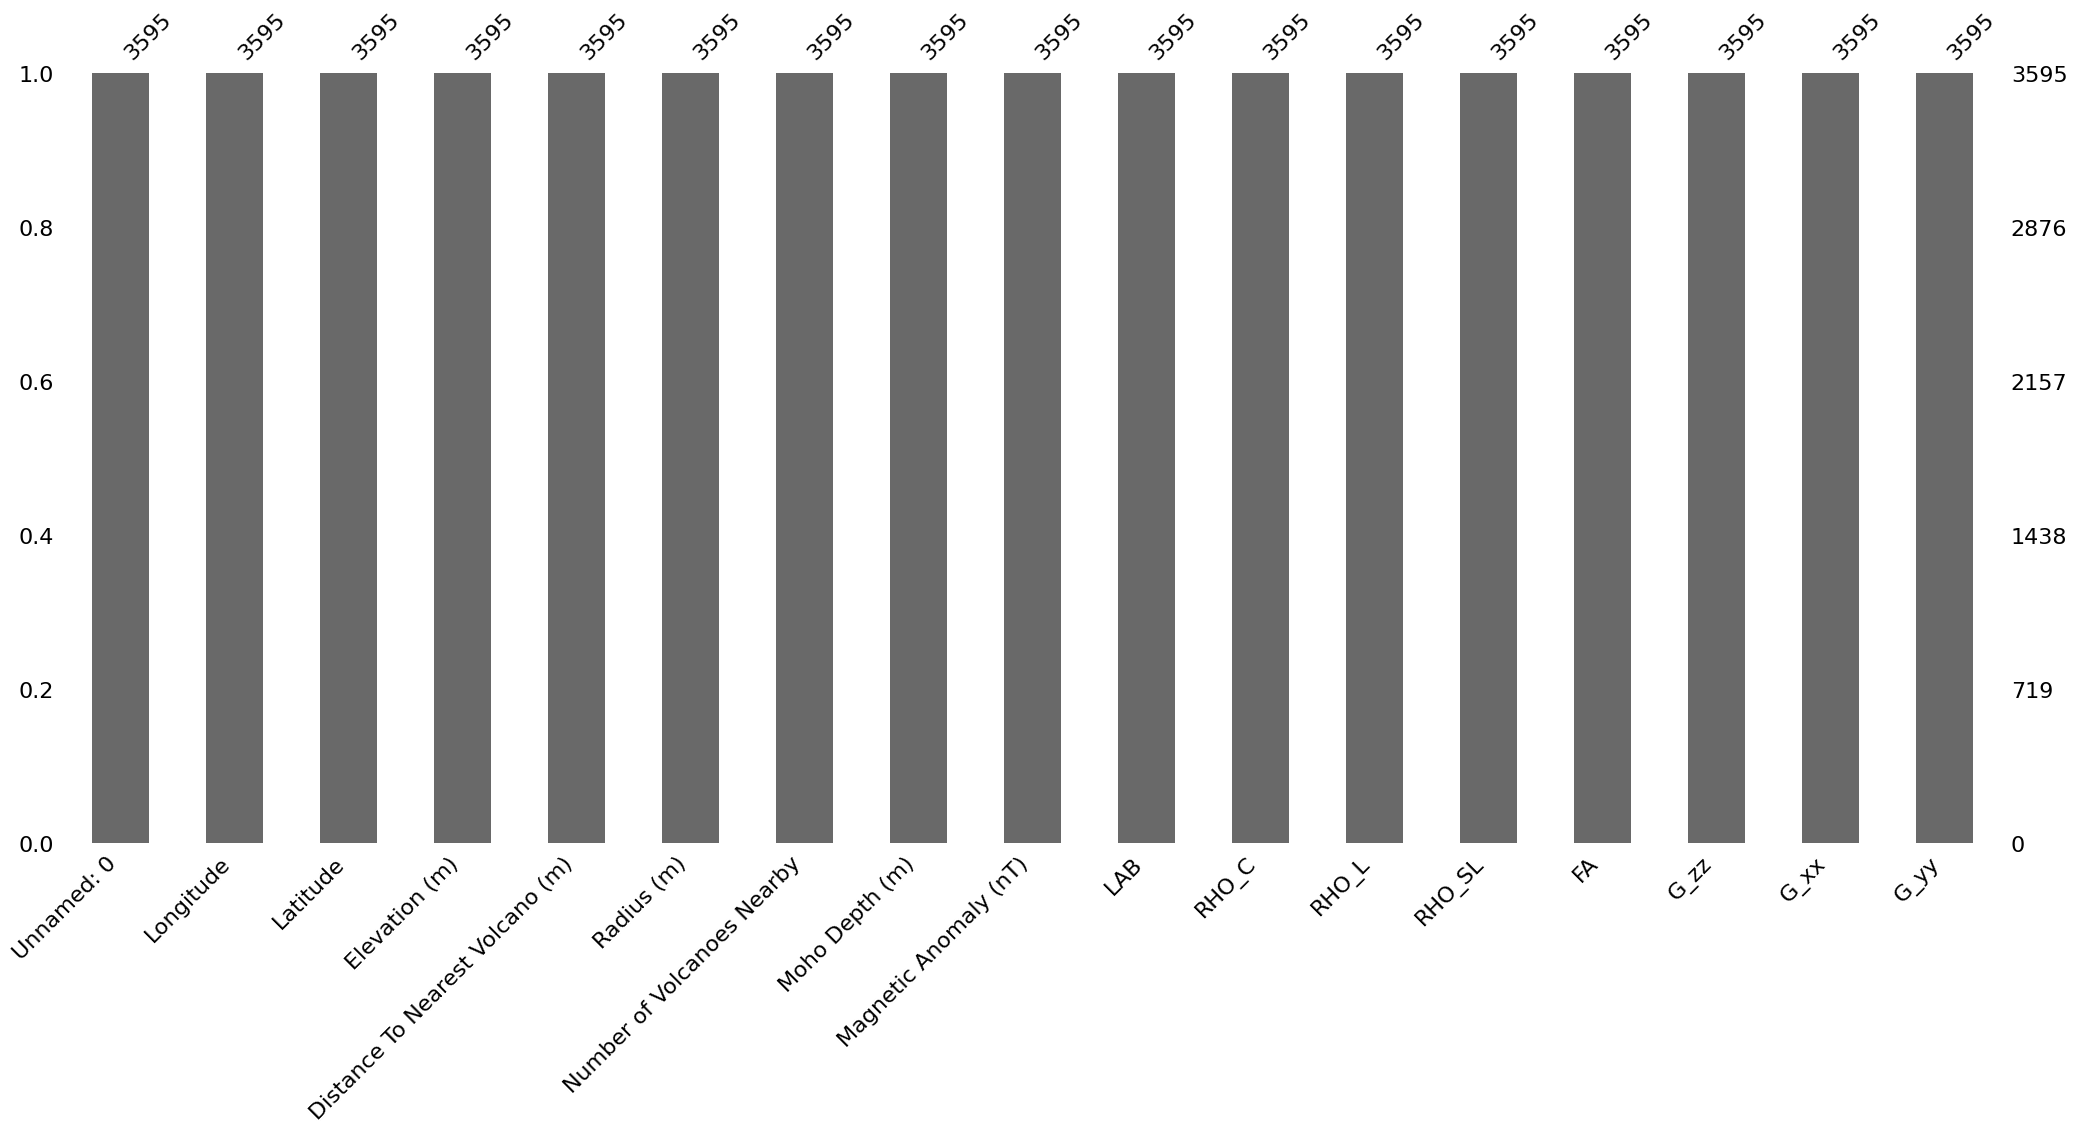

In [53]:
mno.bar(points)

### Column Mapping

In [54]:
column_name_mapping = {
    'RHO_C': 'Crustal Density (kg/m³)',
    'RHO_L': 'Lithospheric Density (kg/m³)',
    'RHO_SL': 'Sub-Lithospheric Density (kg/m³)',
    'FA': 'Flexural Rigidity (Pa⁻¹)',
    'G_zz': 'Gravitational Acceleration z-component (m/s²)',
    'G_xx': 'Gravitational Acceleration x-component (m/s²)',
    'G_yy': 'Gravitational Acceleration y-component (m/s²)'
}

# Rename the columns using the dictionary
points = points.rename(columns=column_name_mapping)

In [73]:
points.to_csv('Nevada/prediction_points.csv', index=False)

In [77]:
points = pd.read_csv('Nevada/prediction_points.csv', index_col=False)


,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,-115.316083,39.056995,2409.411765,243486.960817,248486.960817,1,-32708.286048,-2.699496,-74203.925994,2712.664919,3293.417075,3438.390875,8.806448,0.156374,-0.071361,-0.090880
1,-115.860218,40.135393,1781.960784,265655.678039,270655.678039,1,-32195.583008,7.537642,-69687.848632,2704.417573,3289.175028,3437.195359,11.448601,0.197711,-0.087277,-0.112201
2,-117.930831,40.436129,1330.196078,128664.067523,133664.067523,1,-31583.185760,-56.182120,-59982.561645,2716.691454,3279.223358,3432.348590,8.191719,0.215606,-0.096024,-0.122369
3,-116.957769,39.278125,1706.666667,166663.710104,171663.710104,1,-32966.777278,58.767490,-74209.614942,2726.131061,3293.440639,3436.757609,12.746653,0.186100,-0.081040,-0.095547
4,-115.834088,39.629036,2334.117647,260405.756087,265405.756087,1,-32500.853292,0.348179,-72286.625847,2710.340106,3291.657519,3437.626731,10.784258,0.181985,-0.080956,-0.102468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,-117.973266,38.391379,2083.137255,102086.259073,107086.259073,2,-34150.315104,56.963220,-63094.601088,2752.084558,3280.166458,3433.289055,10.584116,0.185415,-0.101972,-0.081599
3591,-117.080660,37.616785,1480.784314,73961.495580,78961.495580,1,-33040.600004,-20.384912,-61384.636440,2749.921450,3279.200812,3432.709167,2.653938,0.142072,-0.075847,-0.062633
3592,-117.667776,40.123484,1179.607843,122043.691389,127043.691389,1,-32082.051914,-83.118450,-63058.919641,2719.613361,3282.106129,3433.446315,9.528481,0.210246,-0.094596,-0.115630
3593,-118.603832,40.876069,1380.392157,151373.112844,156373.112844,1,-30581.223891,220.870510,-58486.998491,2716.231553,3278.601898,3430.940209,7.185304,0.213822,-0.092416,-0.128905


In [78]:
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,2,-115.316083,39.056995,2409.411765,243486.960817,248486.960817,1,-32708.286048,-2.699496,-74203.925994,2712.664919,3293.417075,3438.390875,8.806448,0.156374,-0.071361,-0.090880
1,3,-115.860218,40.135393,1781.960784,265655.678039,270655.678039,1,-32195.583008,7.537642,-69687.848632,2704.417573,3289.175028,3437.195359,11.448601,0.197711,-0.087277,-0.112201
2,7,-117.930831,40.436129,1330.196078,128664.067523,133664.067523,1,-31583.185760,-56.182120,-59982.561645,2716.691454,3279.223358,3432.348590,8.191719,0.215606,-0.096024,-0.122369
3,8,-116.957769,39.278125,1706.666667,166663.710104,171663.710104,1,-32966.777278,58.767490,-74209.614942,2726.131061,3293.440639,3436.757609,12.746653,0.186100,-0.081040,-0.095547
4,12,-115.834088,39.629036,2334.117647,260405.756087,265405.756087,1,-32500.853292,0.348179,-72286.625847,2710.340106,3291.657519,3437.626731,10.784258,0.181985,-0.080956,-0.102468


### Normalization

In [79]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)','Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)', 'Magnetic Anomaly (nT)',
                        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                        'Flexural Rigidity (Pa⁻¹)',]

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
points[columns_to_normalize] = scaler.fit_transform(points[columns_to_normalize])

In [80]:
# Save the normalized data to a new CSV file
points.to_csv('Nevada/normalized_pred.csv', index=False)

In [81]:
points = pd.read_csv('normalized_full_prediction.csv')
points.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,2,-115.316083,39.056995,0.588785,0.795252,248486.960817,0.0,0.538287,0.368148,0.051330,0.207791,0.949961,0.929247,0.657166,0.156374,-0.071361,-0.090880
1,3,-115.860218,40.135393,0.355140,0.869231,270655.678039,0.0,0.634335,0.391123,0.246526,0.093891,0.791602,0.793505,0.767618,0.197711,-0.087277,-0.112201
2,7,-117.930831,40.436129,0.186916,0.412077,133664.067523,0.0,0.749058,0.248116,0.666013,0.263399,0.420097,0.243191,0.631468,0.215606,-0.096024,-0.122369
3,8,-116.957769,39.278125,0.327103,0.538886,171663.710104,0.0,0.489863,0.506099,0.051084,0.393763,0.950841,0.743802,0.821882,0.186100,-0.081040,-0.095547
4,12,-115.834088,39.629036,0.560748,0.851712,265405.756087,0.0,0.577147,0.374988,0.134201,0.175684,0.884275,0.842484,0.739846,0.181985,-0.080956,-0.102468


### Prediction

In [82]:
selected_features = ['Elevation (m)',
                    'Distance To Nearest Volcano (m)',
                    'Number of Volcanoes Nearby',
                    'Moho Depth (m)',
                    'LAB',
                    'Magnetic Anomaly (nT)',
                    'Crustal Density (kg/m³)',
                    'Lithospheric Density (kg/m³)',
                    'Sub-Lithospheric Density (kg/m³)',
                    'Gravitational Acceleration z-component (m/s²)',
                    'Gravitational Acceleration x-component (m/s²)',
                    'Gravitational Acceleration y-component (m/s²)']

# Create a new DataFrame with the selected columns
selected_data = points[selected_features]

X_new = selected_data.values  # Convert the DataFrame to a 2D numpy array

# Use the XGBoost model to make predictions
y_pred_new = best_xgb_model.predict(X_new)

# Add the predicted values to the points DataFrame
points['Predicted Geothermal Gradient (°C/Km)'] = y_pred_new

In [84]:
points.to_csv('Nevada/predicted.csv', index=False)
predicted_new = pd.read_csv('Nevada/predicted.csv')
predicted_new.head()

,Unnamed: 0,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Predicted Geothermal Gradient (°C/Km)
0,2,-115.316083,39.056995,0.588785,0.795252,248486.960817,0.0,0.538287,0.368148,0.051330,0.207791,0.949961,0.929247,0.657166,0.156374,-0.071361,-0.090880,30.461382
1,3,-115.860218,40.135393,0.355140,0.869231,270655.678039,0.0,0.634335,0.391123,0.246526,0.093891,0.791602,0.793505,0.767618,0.197711,-0.087277,-0.112201,23.861017
2,7,-117.930831,40.436129,0.186916,0.412077,133664.067523,0.0,0.749058,0.248116,0.666013,0.263399,0.420097,0.243191,0.631468,0.215606,-0.096024,-0.122369,26.264456
3,8,-116.957769,39.278125,0.327103,0.538886,171663.710104,0.0,0.489863,0.506099,0.051084,0.393763,0.950841,0.743802,0.821882,0.186100,-0.081040,-0.095547,28.349281
4,12,-115.834088,39.629036,0.560748,0.851712,265405.756087,0.0,0.577147,0.374988,0.134201,0.175684,0.884275,0.842484,0.739846,0.181985,-0.080956,-0.102468,28.569483


## Plot map

/tmp/ipykernel_969/454301483.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_969/454301483.py:36: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  nevada.boundary.plot(ax=ax, linewidth=0.5, color='black', aspect=1)


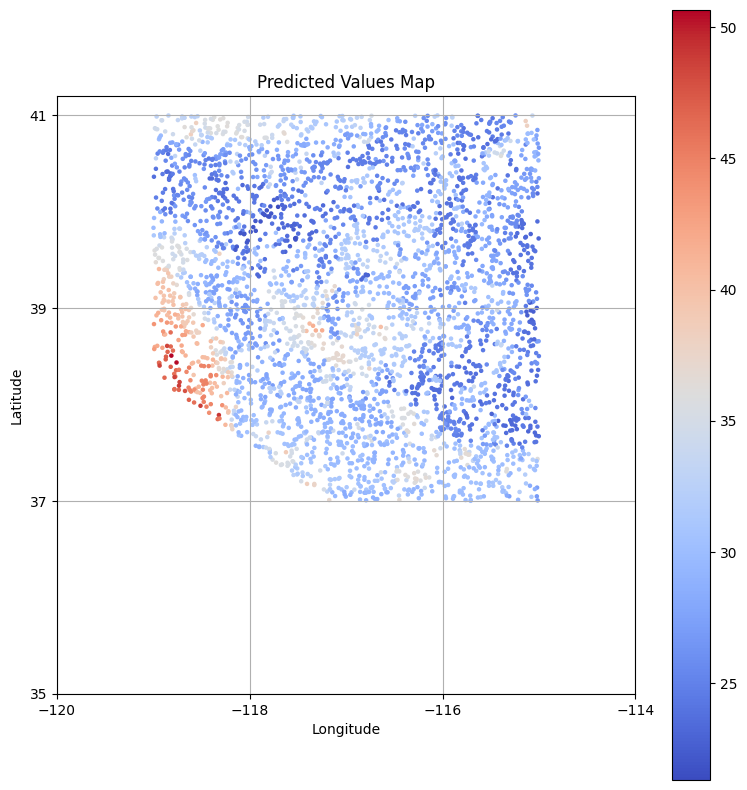

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(predicted_new, geometry=gpd.points_from_xy(predicted_new['Longitude'], predicted_new['Latitude']))

# Determine the color range
vmin = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min()
vmax = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max()

# Create a subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the predicted values
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Predicted Values Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on your data's latitude and longitude
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for latitude and longitude
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include Nevada
nevada = world[world['name'] == 'Nevada']

# Plot Nevada borders
nevada.boundary.plot(ax=ax, linewidth=0.5, color='black', aspect=1)

# Show the plot
plt.tight_layout()
plt.show()
